## Setup

In [6]:
import math

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

## Class

In [46]:
class BERTClass():

    def __init__(self, original_df, num_samples, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=4)
        
        self.original_df = original_df
        self.num_samples = num_samples
        
        self.dataset = self.preprocess()
        
        train_dataset, eval_dataset, test_dataset = self.split_data()

        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.test_dataset = test_dataset

    # helper function
    def convert_to_HF(self, df):
        dataset = Dataset.from_pandas(df)
        if "__index_level_0__" in list(dataset.features.keys()):
            dataset = dataset.remove_columns(["__index_level_0__"])
        dataset = dataset.class_encode_column("type")
        
        dataset = dataset.rename_column("url", "text")
        dataset = dataset.rename_column("type", "label")
    
        return dataset

    # helper function
    def tokenize(self, data):
        return self.tokenizer(data["text"], padding="max_length", return_tensors="pt")
    
    def preprocess(self): 
        weights = 1.0 / self.original_df.groupby('type')['type'].transform('count')
        
        df = original_df.sample(n=self.num_samples, replace=False, random_state=42, weights=weights)

        dataset = self.convert_to_HF(df)
        
        tokenized_dataset = dataset.map(self.tokenize, batched=True)

        self.target_labels = dataset.features["label"].names

        return tokenized_dataset

    # helper function
    def split_data(self):
        split_dataset = self.dataset.train_test_split(test_size=0.1)
        
        train_eval_dataset = split_dataset["train"]
        
        train_eval_split_dataset = train_eval_dataset.train_test_split(test_size=0.1)

        train_dataset = train_eval_split_dataset["train"]
    
        eval_dataset = train_eval_split_dataset["test"]

        test_dataset = split_dataset["train"]

        return (train_dataset, eval_dataset, test_dataset)

    # helper function
    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        sum = 0
        for i in range(len(labels)):
            raw_logits = logits[i]
            
            exp_logits = np.exp(raw_logits)
            norm_logits = exp_logits / np.sum(exp_logits, axis=0)
            chosen_value = norm_logits[labels[i]]
            
            sum += np.log(chosen_value)
        sum /= -len(labels)
        return {"cross_entropy": sum}
    
    def train(self, num_train_epochs, logging_steps, learning_rate, per_device_train_batch_size, weight_decay):
        training_args = TrainingArguments(output_dir="results", 
                                          num_train_epochs=num_train_epochs,
                                          logging_steps=logging_steps,
                                          learning_rate=learning_rate,
                                          per_device_train_batch_size=per_device_train_batch_size,
                                          weight_decay=weight_decay,
                                          evaluation_strategy="epoch"
                                         )

        self.trainer = Trainer(model=self.model,
                          args=training_args,
                          train_dataset=self.train_dataset,
                          eval_dataset=self.eval_dataset,
                          compute_metrics=self.compute_metrics,
                        )

        self.trainer.train()

    def evaluate(self):
        predictions = self.trainer.predict(self.test_dataset)
        predicted_labels = np.argmax(predictions.predictions, axis=-1)
        true_labels = self.test_dataset["label"]
        
        conf_mat = confusion_matrix(true_labels, predicted_labels, labels=np.arange(4))
        
        plt.figure(figsize=(7, 4))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=self.target_labels, yticklabels=self.target_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        report = classification_report(true_labels, predicted_labels, labels=np.arange(4), target_names=self.target_labels, output_dict=False)
        print(report)

## Load in the Data

In [47]:
original_df = pd.read_csv("malicious_phish.csv")
original_df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [48]:
bert = BERTClass(original_df, 1000, "./bert-base-uncased/")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./bert-base-uncased/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 3218.83 examples/s]


In [49]:
bert.train(num_train_epochs=5,
          logging_steps=1,
          learning_rate=5e-5,
          per_device_train_batch_size=8,
          weight_decay=0
          )

/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Cross Entropy
1,0.089300,0.495503,0.495504
2,0.036800,0.442410,0.442410
3,0.008200,0.500684,0.500684
4,0.004100,0.374969,0.374969
5,0.003200,0.481913,0.481913


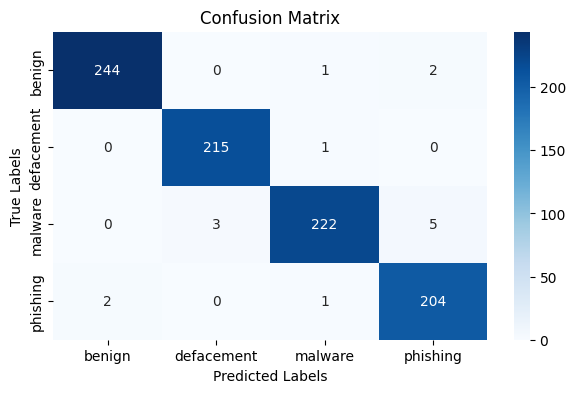

              precision    recall  f1-score   support

      benign       0.99      0.99      0.99       247
  defacement       0.99      1.00      0.99       216
     malware       0.99      0.97      0.98       230
    phishing       0.97      0.99      0.98       207

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



In [50]:
bert.evaluate()